# The Math of Similarity

**Embeddings** are lists of numbers, specifically arrays of floating-point numbers, that are predictions from a model trained to represent high-dimensional data (text, images, video, audio) in a lower-dimensional space. This effectively captures semantic meaning and structural relationships within the data.

* These lists of floats form **vector spaces** where each number represents a latent feature.
* Mathematical operations on these embeddings are used to calculate **distance metrics** to measure similarity.
* This notebook will introduce the math behind common distance metrics and provide intuition for what each is measuring.

**Disclaimer**

This notebook uses math. For some, it will be too much, and for those folks, I promise to keep it light and be highly descriptive with visuals. For others, it might be too little, and you'll want to point out a million little details I passed over or left out — I agree with you! For both groups, this is meant to answer the most common questions I hear about vector similarity in this new world of retrieval augmented generation (RAG) and LLMs.

**What you will learn**

* Embeddings are vectors. Vectors are series of numbers that represent both a direction and a magnitude (length).
* Calculating magnitude (length) is done with vector norms. There are multiple ways to measure length.
* Normalization makes it easier to compare vectors by making them all the same length so that only the angle separates them.
* Similarity metrics measure the distance between vectors. Some use just the angle, others the angle and the magnitude, or just the brute force distance between them.

**TL;DR**

If you need vector similarity for matching chunks for an LLM, then:

* Use normalized vectors.
    * Your embedding API likely already gives you normalized embeddings.
* Use **dot product similarity**.
    * It's computationally faster, and guess what? It's identical to **cosine similarity** with normalized vectors!

---
## Setup

Keep it simple! A full walk through with just [numpy](https://numpy.org/doc/stable/index.html) (for mathy things) and [matplotlib](https://matplotlib.org/) (for seeing the math in pictures).

### Installs (If Needed)

In [106]:
# tuples of (import name, install name, min_version)
packages = [
    ('numpy', 'numpy'),
    ('matplotlib', 'matplotlib')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Packages

In [107]:
import numpy as np
import matplotlib.pyplot as plt

---
## Create Example Embeddings


In [5]:
embeddings = np.random.rand(1000, 2)

In [12]:
example_a = embeddings[0]
example_b = embeddings[-1]

In [13]:
example_a, example_b

(array([0.71395259, 0.45081254]), array([0.52904412, 0.26408864]))

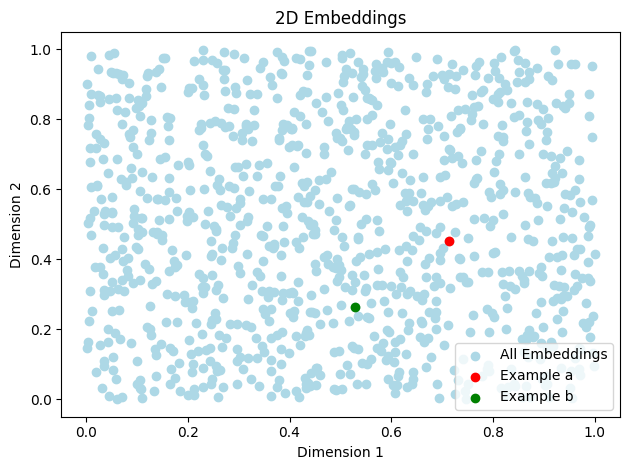

In [22]:
# Create a scatter plot of all embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], color='lightblue', label='All Embeddings')

# Plot the two examples with different colors
plt.scatter(example_a[0], example_a[1], color='red', label='Example a')
plt.scatter(example_b[0], example_b[1], color='green', label='Example b')

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

---
## Embeddings Are Vectors

The two example embeddings can be plotted as vectors with origin (0,0):


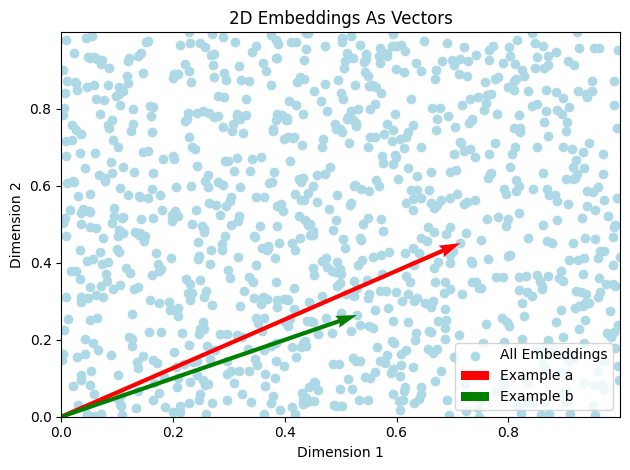

In [51]:
# Create a scatter plot of all embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], color='lightblue', label='All Embeddings')

# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a[0], example_a[1], angles='xy', scale_units='xy', scale=1, color='red', label='Example a')
plt.quiver(0, 0, example_b[0], example_b[1], angles='xy', scale_units='xy', scale=1, color='green', label='Example b')

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings[:, 0]))
plt.ylim(0, max(embeddings[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings As Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

---
## Magnitude of Vectors (aka norms)

> Learning a bit about vector math can be very helpful here!  Let's keep it light and geometrically motivated.

When we think magnitude and see a line like the red and green ones for our example vectors we think **length**.  Turns out that is a great way to think about it.  But remember, the line represents our vector (an embedding) and could have many more dimensions than we can visualize.  Beyond two dimensions the distance could be a bit more complex to think about.  This section will show the most common norms, their calcuations, and visually represent them for stronger intuition.  

A tiny bit of notation.  A norm of a value is represented by what appears to be double absolute value signs. For instance, the norm for a vector `a` would be notated as: $||a||$.  Extending this a bit is the inclusion of the type of norm with subscript value like: $||a||_2$.  When the subscript is missing it typically means 2 which is the Euclidean norm that is covered first below.

Read more about [norms](https://en.wikipedia.org/wiki/Norm_(mathematics))

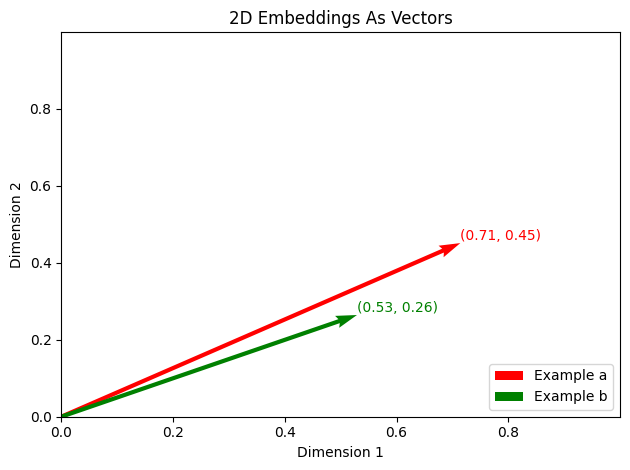

In [97]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a[0], example_a[1], angles='xy', scale_units='xy', scale=1, color='red', label='Example a')
plt.quiver(0, 0, example_b[0], example_b[1], angles='xy', scale_units='xy', scale=1, color='green', label='Example b')

# Annotate the ends of the vectors with their coordinates
plt.text(example_a[0], example_a[1], f"({example_a[0]:.2f}, {example_a[1]:.2f})", color='red', ha='left', va='bottom')
plt.text(example_b[0], example_b[1], f"({example_b[0]:.2f}, {example_b[1]:.2f})", color='green', ha='left', va='bottom')


# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings[:, 0]))
plt.ylim(0, max(embeddings[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings As Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

---
### Euclidean Norm (L2 norm)

The Euclidean norm, or L2 norm, is the straight line distance: notated as $||a||_2$. Distance is calculated by taking the square root of the sum of squared coordinates.  In math that looks like:

$$
||a||_2 = \sqrt{\sum_{i=0}^{n} (a_i)^2} = \sqrt{(a_0)^2 + (a_1)^2 + ... (a_n)^2}
$$

Now let's calculate this for `example_a` in three difference ways:
- manually
- brute force
- with a function

Review the vector for the `example_a` embedding:

In [67]:
example_a

array([0.71395259, 0.45081254])

Manually calculate the L2 norm without any vector math:

In [74]:
np.sqrt(example_a[0]**2 + example_a[1]**2)

0.8443697313870246

Calculate the L2 norm using vector math to compute the squared values by squaring the vector:

In [75]:
np.sqrt(np.sum(example_a**2))

0.8443697313870246

Use a function to directly compute the L2 norm:

In [77]:
np.linalg.norm(example_a, 2)

0.8443697313870246

---
### Manhattan Norm (L1 norm)

The Manhattan norm, or L1 norm, is often referred to as the taxicab norm: notated as $||a||_1$.  Rather than directly going between coordinates it uses an imaginary grid, like a city, and traverses the distance using only horizontal and vertical movements.  In other words, you sum the absolute values of each coordinate representing a distance moved.  In math that looks like:

$$
||a||_1 = \sum_{i=0}^{n} |a_i| = |a_0| + |a_1| + ... |a_n|
$$

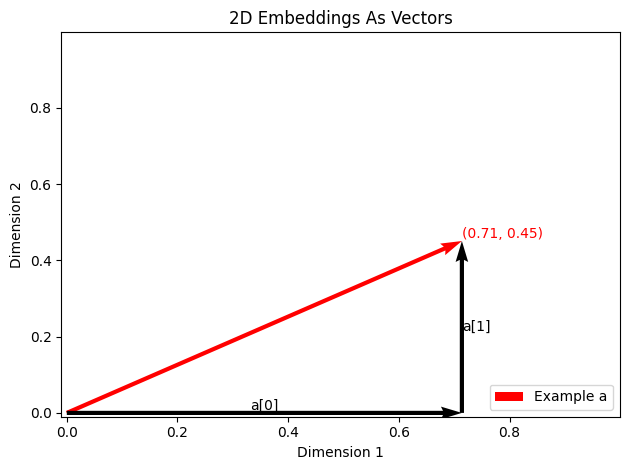

In [85]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a[0], example_a[1], angles='xy', scale_units='xy', scale=1, color='red', label='Example a')

# Annotate the ends of the vectors with their coordinates
plt.text(example_a[0], example_a[1], f"({example_a[0]:.2f}, {example_a[1]:.2f})", color='red', ha='left', va='bottom')

# Add a vector from the origin to example_a[0]
plt.quiver(0, 0, example_a[0], 0, angles='xy', scale_units='xy', scale=1, color='black')
plt.text(example_a[0] / 2, 0, 'a[0]', color='black', ha='center', va='bottom')
plt.quiver(example_a[0], 0, 0, example_a[1], angles='xy', scale_units='xy', scale=1, color='black')
plt.text(example_a[0], example_a[1] / 2, 'a[1]', color='black', ha='left', va='center')


# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(-0.01, max(embeddings[:, 0]))
plt.ylim(-0.01, max(embeddings[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings As Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

Review the vector for the `example_a` embedding:

In [86]:
example_a

array([0.71395259, 0.45081254])

Manually calculate the L1 norm without any vector math:

In [87]:
abs(example_a[0]) + abs(example_a[1])

1.1647651256280853

Calculate the L1 norm using vector math to compute the absolute values for the vector:

In [88]:
np.sum(np.abs(example_a))

1.1647651256280853

Use a function to directly compute the L1 norm:

In [89]:
np.linalg.norm(example_a, 1)

1.1647651256280853

### Maximum Norm (L&#8734; norm)

The maximum norm, or infinity norm is maximum component length of the vector: notated as $||a||_\infty$.  This represents the magnitude as the single component with the largest magnitude, or absolute value.  The math looks like:

$$
||a||_\infty = \max(|a_i|, i \in [0, n]) = \max(|a_0|, |a_1|, ..., |a_n|)
$$


Review the vector for the `example_a` embedding:

In [90]:
example_a

array([0.71395259, 0.45081254])

Manually calculate the L&#8734; norm without any vector math:

In [94]:
max([abs(example_a[0]), abs(example_a[1])])

0.7139525904474127

Calculate the L&#8734; norm using vector math to compute the absolute values for the vector:

In [95]:
np.max(np.abs(example_a))

0.7139525904474127

Use a function to directly compute the L&#8734; norm:

In [96]:
np.linalg.norm(example_a, np.inf)

0.7139525904474127

---
## Normalizing Vectors

We will eventually see that normalizing vectors makes interpretation and comparison easier.  It also simplifies calcuations and even makes some distance measures identical.  First, let's understand the intuition of normalization.  

The embeddings, vectors, represent a direction and distance.  Without knowing the possible distance it is hard to interpret how far is a little, typical, or a lot.  Putting vectors on a common scale makes them directly comparable and interpretable.  The most common way of doing this is to divide each vector by its magnitude which results in a new magnitude of 1.

We learned all about **magnitude** above and know that norms measure the magnitude.  Dividing a vector by its magnitude has this math:
> note that a normalized vector is indicated by giving it a hat: $\hat{a}$

$$
\hat{a} = \frac{a}{||a||_2}
$$



Normalize the examples and plot to compare the original to the normalized embeddings:

In [248]:
example_a_normalized = example_a / np.linalg.norm(example_a, 2)
example_b_normalized = example_b / np.linalg.norm(example_b, 2)

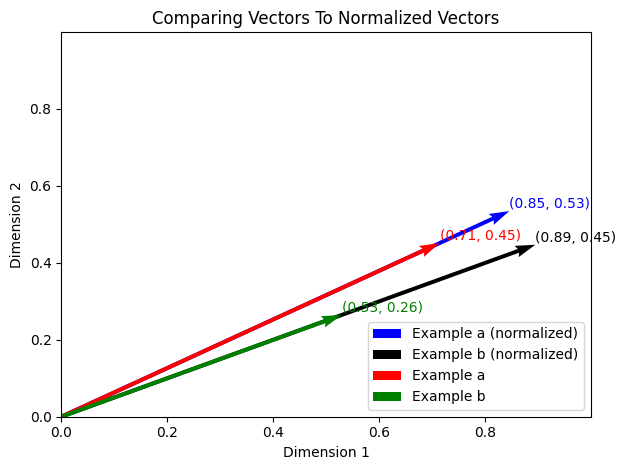

In [262]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a_normalized[0], example_a_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Example a (normalized)')
plt.quiver(0, 0, example_b_normalized[0], example_b_normalized[1], angles='xy', scale_units='xy', scale=1, color='black', label='Example b (normalized)')
plt.quiver(0, 0, example_a[0], example_a[1], angles='xy', scale_units='xy', scale=1, color='red', label='Example a')
plt.quiver(0, 0, example_b[0], example_b[1], angles='xy', scale_units='xy', scale=1, color='green', label='Example b')

# Annotate the ends of the vectors with their coordinates
plt.text(example_a[0], example_a[1], f"({example_a[0]:.2f}, {example_a[1]:.2f})", color='red', ha='left', va='bottom')
plt.text(example_b[0], example_b[1], f"({example_b[0]:.2f}, {example_b[1]:.2f})", color='green', ha='left', va='bottom')
plt.text(example_a_normalized[0], example_a_normalized[1], f"({example_a_normalized[0]:.2f}, {example_a_normalized[1]:.2f})", color='blue', ha='left', va='bottom')
plt.text(example_b_normalized[0], example_b_normalized[1], f"({example_b_normalized[0]:.2f}, {example_b_normalized[1]:.2f})", color='black', ha='left', va='bottom')

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings[:, 0]))
plt.ylim(0, max(embeddings[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Comparing Vectors To Normalized Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

Normalize all the embeddings and plot them:

In [264]:
# Calculate the magnitudes of the vectors
magnitudes = np.linalg.norm(embeddings, axis=1, keepdims=True)
# Avoid division by zero
magnitudes[magnitudes == 0] = 1
# create normalized embeddings using the magnitudes:
embeddings_normalized = embeddings / magnitudes

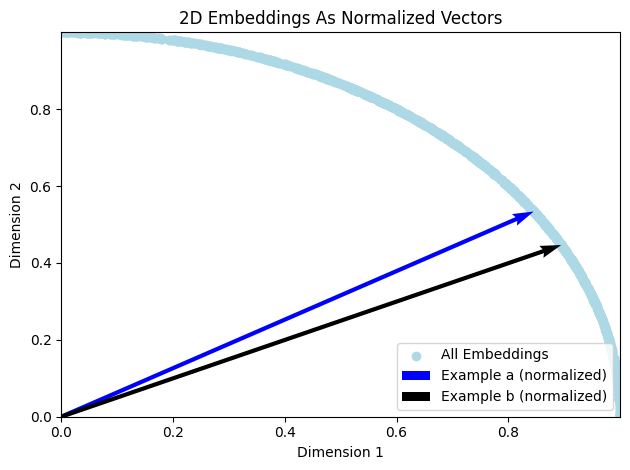

In [266]:
# Create a scatter plot of all embeddings
plt.scatter(embeddings_normalized[:, 0], embeddings_normalized[:, 1], color='lightblue', label='All Embeddings')

# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a_normalized[0], example_a_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Example a (normalized)')
plt.quiver(0, 0, example_b_normalized[0], example_b_normalized[1], angles='xy', scale_units='xy', scale=1, color='black', label='Example b (normalized)')

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings_normalized[:, 0]))
plt.ylim(0, max(embeddings_normalized[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings As Normalized Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

**Interpretation**

Dividing by the magnitude makes all vectors have magnitude 1.  This makes the vectors appear to be on a circle with radius 1 (the unit circle).  Similar vectors would be close to each other on the circumferance which means they have a small angle between them.  Hold onto this concept as it will help understand the difference (or similarity) between **dot product similarity** and **cosine similarity**.

---
## Calculating Distance Measures

This section build on the knowledge of measuring length (magnitude, norms), and putting vectors on a interpetable scale (normalization).  Now, we can look at methods to compare vectors and interpret the relationship - **Distance Measures**. Specifically:
- Euclidean Distance
    - the straight line distance between two points represented by vectors
- Dot Product Similarity
    - Considers both the magnitude of each vector and the angle between them
- Cosine Similarity
    - Consider just the angle between vectors
    
In the following section each distance measure is presented for the vectors and the normalized vectors.

---
### Euclidean Distance

The **Euclidean distance** is the length of the straight-line connecting two points.  In math this looks like:

$$
d(a, b) = \sqrt{\sum_{i=0}^{n} (a_i - b_i)^2} = \sqrt{(a_0 - b_0)^2 + (a_1 - b_1)^2 + ... (a_n - b_n)^2}
$$

Remember the section above about magnitudes, aka norms?  Well the L2 norm has a similar name: Euclidean Norm.  That is not just a coincidence as we can directly use L2 norm to calculate this rather than this longer form calculation!

$$
d = a - b
$$

$$
||d||_2 = \sqrt{\sum_{i=0}^{n} (d_i)^2} = \sqrt{(d_0)^2 + (d_1)^2 + ... (d_n)^2}
$$

**Interpretation**

What is the interpretation of the length?  Well, it depends on the scale of the data.  

- For the raw vectors: 
    - In this case the vectors are randomly generated from uniform values in the range (0, 1).  That means the minimum distance would be 0 and max would be $\sqrt 2$ (think about distance between (0, 1) and (1,0)).
- For the normalized vectors:
    - Normalizing vectors brings them to length 1. That means the maximum distance for two vectors at 180 degrees would be 2 and the min would be 0.

Read more about [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)

#### Between Vectors

> See the same workflow for normalized vectors follows this sections.

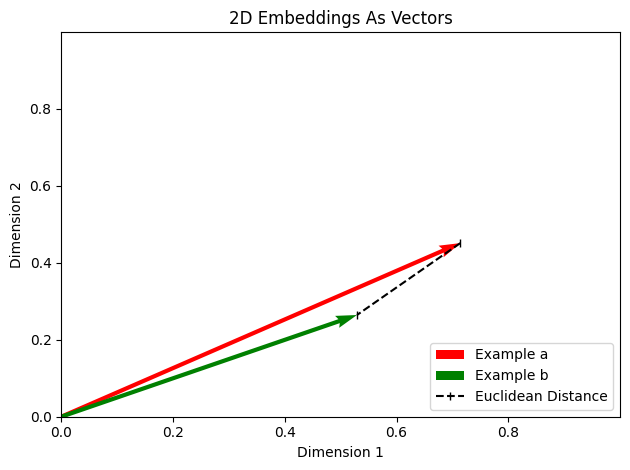

In [120]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a[0], example_a[1], angles='xy', scale_units='xy', scale=1, color='red', label='Example a')
plt.quiver(0, 0, example_b[0], example_b[1], angles='xy', scale_units='xy', scale=1, color='green', label='Example b')

# Draw a line connecting the two examples with ends indicating distance
plt.plot([example_a[0], example_b[0]], [example_a[1], example_b[1]], linestyle='--', marker='|', color='black', label='Euclidean Distance')

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings[:, 0]))
plt.ylim(0, max(embeddings[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings As Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

Calculate the distance vector:

In [110]:
distance = example_a - example_b
distance

array([0.18490847, 0.1867239 ])

Calculate the Euclidean distance directly:

In [111]:
euclidean_distance = np.sqrt(np.sum((distance)**2))
euclidean_distance

0.2627869041125236

Calculate the Euclidean distance as the L2 Norm:

In [112]:
euclidean_distance = np.linalg.norm(distance, 2)
euclidean_distance

0.2627869041125236

#### Between Normalized Vectors

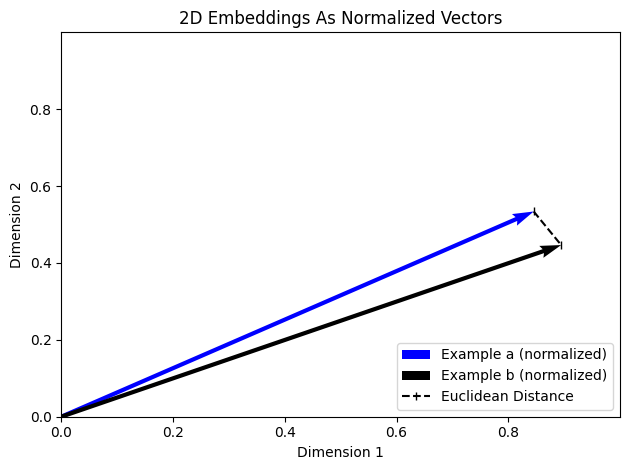

In [267]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a_normalized[0], example_a_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Example a (normalized)')
plt.quiver(0, 0, example_b_normalized[0], example_b_normalized[1], angles='xy', scale_units='xy', scale=1, color='black', label='Example b (normalized)')

# Draw a line connecting the two examples with ends indicating distance
plt.plot([example_a_normalized[0], example_b_normalized[0]], [example_a_normalized[1], example_b_normalized[1]], linestyle='--', marker='|', color='black', label='Euclidean Distance')

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings_normalized[:, 0]))
plt.ylim(0, max(embeddings_normalized[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings As Normalized Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

Calculate the distance vector:

In [268]:
distance_normalized = example_a_normalized - example_b_normalized
distance_normalized

array([-0.04917522,  0.0872771 ])

Calculate the Euclidean distance directly:

In [269]:
euclidean_distance_normalized = np.sqrt(np.sum((distance_normalized)**2))
euclidean_distance_normalized

0.10017731085203486

Calculate the Euclidean distance as the L2 Norm:

In [270]:
euclidean_distance_normalized = np.linalg.norm(distance_normalized, 2)
euclidean_distance_normalized

0.10017731085203486

---
### Dot Product Similarity

The **dot product** is a similarity metric for two vectors, in our case embeddings.  This metrics adds the product (multiplication) of each component of the vectors.  In math that looks like:

$$
a \cdot b = \sum_{i=0}^{n} a_i b_i = a_0 b_0 + a_1 b_1 + ... + a_n b_n
$$

Actually, the **dot product** is geometrically represented by the product of the magnitudes of each vectors multiplied by the cosine of the angle between them:

$$
a \cdot b = ||a||_2 ||b||_2 \cos(\alpha)
$$

**Interpretation**

Looking at the formula we see three parts: the magnitude of both vectors as well as the angle between them.
- values can be positive or negative
- which side of 0 is determined by the angle
    - When $\alpha < 90$ dot product is > 0
    - When $\alpha = 90$ dot product is 0
    - When $\alpha > 90$ dot product is < 0
- larger magnitudes generally lead to larger dot products, even if angles are the same
- smaller angles lead to larger dot products
- the range is not fixed
    - normalizing vectors is common to help interpretation
    - normalizing means dividing vectors by their magnitude to create unit vectors with magnitude 1
    - the dot product of normalized vectors is identical to **cosine similarity** and ranges from -1 to 1

Read more about [dot product](https://en.wikipedia.org/wiki/Dot_product)

#### Between Vectors

> See the same workflow for normalized vectors follows this sections.

Calculate the dot product geometrically by first calculating the angle between the vectors (notice that the dot product is still needed):

In [151]:
angle = np.arccos(np.dot(example_a, example_b) / (np.linalg.norm(example_a, 2) * np.linalg.norm(example_b, 2))) # in radians
angle = np.degrees(angle)
angle

5.742139874110529

Now complete the geometric representation of the dot product:

In [152]:
dot_product = np.linalg.norm(example_a)*np.linalg.norm(example_b)*np.cos(np.radians(angle))
dot_product

0.4967668876835385

Calculate the dot product directly:

In [153]:
dot_product = np.sum([example_a[i] * example_b[i] for i in range(len(example_a))])
dot_product

0.4967668876835385

Calcuate the dot product with the `np.dot` function:

In [154]:
dot_product = np.dot(example_a, example_b)
dot_product

0.4967668876835385

**Bonus:** dot product is also known as the inner product, or more simply matrix multiplication.  For that reason there are actually similar functions in numpy that accomplish the same result:
> Extra details for the curious along with links:
> - [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html): can handle vectors (1D, and higher order 2D).  For higher dimensions it performs matrix multiplication (np.matmul) over specific axes. It is a sum product over specific axes.
> - [np.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html): designed for matrix operations (2D or more) and cannot multiply by a scalar. Handles stacks of matricies.
> - [np.inner](https://numpy.org/doc/stable/reference/generated/numpy.inner.html): inner product of vectors (1D) or sum product over the last axes for higher order (a bit different than default of np.dot).

In [242]:
np.matmul(example_a, example_b)

0.4967668876835385

In [243]:
np.inner(example_a, example_b)

0.4967668876835385

#### Between Normalized Vectors

Calculate the dot product geometrically by first calculating the angle between the vectors (notice that the dot product is still needed):

In [271]:
angle_normalized = np.arccos(np.dot(example_a_normalized, example_b_normalized) / (np.linalg.norm(example_a_normalized, 2) * np.linalg.norm(example_b_normalized, 2))) # in radians
angle_normalized = np.degrees(angle_normalized)
angle_normalized

5.742139874110529

Now complete the geometric representation of the dot product:

In [272]:
dot_product_normalized = np.linalg.norm(example_a_normalized)*np.linalg.norm(example_b_normalized)*np.cos(np.radians(angle_normalized))
dot_product_normalized

0.9949822531952274

Calculate the dot product directly:

In [273]:
dot_product_normalized = np.sum([example_a_normalized[i] * example_b_normalized[i] for i in range(len(example_a_normalized))])
dot_product_normalized

0.9949822531952274

Calcuate the dot product with the `np.dot` function:

In [274]:
dot_product_normalized = np.dot(example_a_normalized, example_b_normalized)
dot_product_normalized

0.9949822531952274

**Bonus:** dot product is also known as the inner product, or more simply matrix multiplication.  For that reason there are actually similar functions in numpy that accomplish the same result:
> Extra details for the curious along with links:
> - [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html): can handle vectors (1D, and higher order 2D).  For higher dimensions it performs matrix multiplication (np.matmul) over specific axes. It is a sum product over specific axes.
> - [np.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html): designed for matrix operations (2D or more) and cannot multiply by a scalar. Handles stacks of matricies.
> - [np.inner](https://numpy.org/doc/stable/reference/generated/numpy.inner.html): inner product of vectors (1D) or sum product over the last axes for higher order (a bit different than default of np.dot).

In [275]:
np.matmul(example_a_normalized, example_b_normalized)

0.9949822531952274

In [276]:
np.inner(example_a_normalized, example_b_normalized)

0.9949822531952274

---
### Cosine Similarity

The **cosine similarity** involves just the angle ($\alpha$) between two vectors. This metric is not impacted by the magnitude/size of the vectors, just the angle ($\alpha$) between them.

Recall the **dot product** calculation above contains the magnitude of both vectors and notice that this calcuation just divides that out to remove it:

$$
\text{cos_sim}(a, b) = \frac{a \cdot b}{||a||_2 \cdot ||b||_2} = \frac{||a||_2 \cdot ||b||_2 \cos(\alpha)}{||a||_2 \cdot ||b||_2} = \cos(\alpha)
$$

>It is common to normalize vectors. Normalizing means dividing vectors by their magnitude to create unit vectors with magnitude 1.  That means the formula above is equivalent to the **dot product** because all the magnitudes are just 1.

**Interpretation**

The cosine of the angle ($\alpha$) ends up on a scale of $[-1, 1]$. That means:
- If the angle between vectors is 0: $\cos(0) = 1$
- If the angle between vectors is 180: $\cos(180) = -1$
- If the angle between vectors is 90: $\cos(90) = 0$

Since the calculation only relies on the angle it does not matter if the vectors are normalized or not.  Computationally the angle calculation actually requires the **dot product** (shown below).  Also, the **dot product** calculation avoids the angle calculation and for normalized vectors which have magnitude 1 it turns out to actually be equal to the **cosine similarity**.  More on this topic in the comparison of distance measures section at the bottom of this workflow.

Read more about [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)

#### Between Vectors

> See the same workflow for normalized vectors follows this sections.

Calculate the cosine similarity by first calculating the angle between the vectors (notice that the dot product is still needed):

In [116]:
angle = np.arccos(dot_product / (np.linalg.norm(example_a, 2) * np.linalg.norm(example_b, 2))) # in radians
angle = np.degrees(angle)
angle

5.742139874110529

In [119]:
cosine_similarity = np.cos(np.radians(angle))
cosine_similarity

0.9949822531952275

Calcualte the cosine similarity using the result of the dot product calculation:

In [118]:
cosine_similarity = dot_product / (np.linalg.norm(example_a, 2) * np.linalg.norm(example_b, 2))
cosine_similarity

0.9949822531952275

Visualize the angle between these vectors:

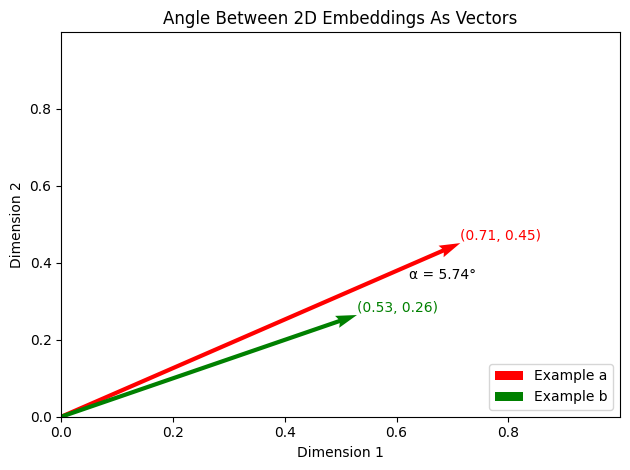

In [127]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a[0], example_a[1], angles='xy', scale_units='xy', scale=1, color='red', label='Example a')
plt.quiver(0, 0, example_b[0], example_b[1], angles='xy', scale_units='xy', scale=1, color='green', label='Example b')

# Annotate the ends of the vectors with their coordinates
plt.text(example_a[0], example_a[1], f"({example_a[0]:.2f}, {example_a[1]:.2f})", color='red', ha='left', va='bottom')
plt.text(example_b[0], example_b[1], f"({example_b[0]:.2f}, {example_b[1]:.2f})", color='green', ha='left', va='bottom')

# Annotate the angle between the vectors
plt.text((example_a[0]+example_b[0])/2, (example_a[1]+example_b[1])/2, f'\u03B1 = {angle:.2f}\u00B0', color='black') 

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings[:, 0]))
plt.ylim(0, max(embeddings[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Angle Between 2D Embeddings As Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

#### Between Normalized Vectors

Calculate the cosine similarity by first calculating the angle between the vectors (notice that the dot product is still needed):

In [277]:
angle_normalized = np.arccos(dot_product_normalized / (np.linalg.norm(example_a_normalized, 2) * np.linalg.norm(example_b_normalized, 2))) # in radians
angle_normalized = np.degrees(angle_normalized)
angle_normalized

5.742139874110529

In [278]:
cosine_similarity_normalized = np.cos(np.radians(angle_normalized))
cosine_similarity_normalized

0.9949822531952275

Calcualte the cosine similarity using the result of the dot product calculation:

In [279]:
cosine_similarity_normalized = dot_product_normalized / (np.linalg.norm(example_a_normalized, 2) * np.linalg.norm(example_b_normalized, 2))
cosine_similarity_normalized

0.9949822531952275

Visualize the angle between these vectors:

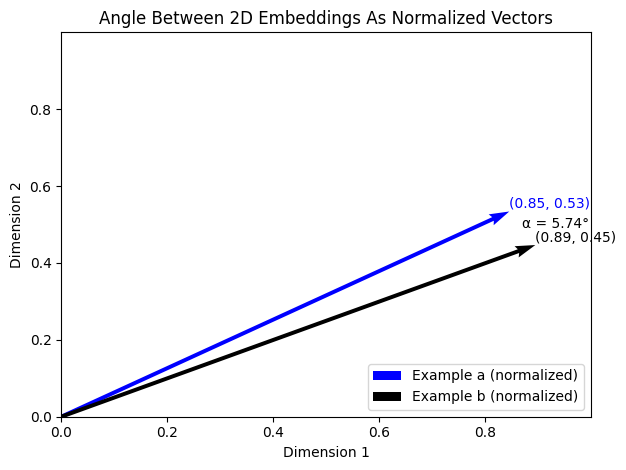

In [280]:
# Plot the two examples as vectors with arrows from the origin
plt.quiver(0, 0, example_a_normalized[0], example_a_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Example a (normalized)')
plt.quiver(0, 0, example_b_normalized[0], example_b_normalized[1], angles='xy', scale_units='xy', scale=1, color='black', label='Example b (normalized)')

# Annotate the ends of the vectors with their coordinates
plt.text(example_a_normalized[0], example_a_normalized[1], f"({example_a_normalized[0]:.2f}, {example_a_normalized[1]:.2f})", color='blue', ha='left', va='bottom')
plt.text(example_b_normalized[0], example_b_normalized[1], f"({example_b_normalized[0]:.2f}, {example_b_normalized[1]:.2f})", color='black', ha='left', va='bottom')

# Annotate the angle between the vectors
plt.text((example_a_normalized[0]+example_b_normalized[0])/2, (example_a_normalized[1]+example_b_normalized[1])/2, f'\u03B1 = {angle_normalized:.2f}\u00B0', color='black') 

# Set the x and y limits to include the origin and the maximum values of the vectors
plt.xlim(0, max(embeddings_normalized[:, 0]))
plt.ylim(0, max(embeddings_normalized[:, 1]))

# Add labels and a legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Angle Between 2D Embeddings As Normalized Vectors')
plt.legend(loc = 'lower right')

# Adjust padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

---
## Interpreting Distance Measures

A common question is how to pick the right distance measure.  Short answer is use dot product.  But why?  Rather than trust me, let's look at the range of possibilites in comparisons and see the calculated values of the distance measures.

### A Baseline Vector

Perhaps this represents a Query Embedding for which we want to find vector matches (chunks)...

In [282]:
base_embedding = np.array([.5, .5])
base_embedding_normalized = base_embedding / np.linalg.norm(base_embedding, 2)

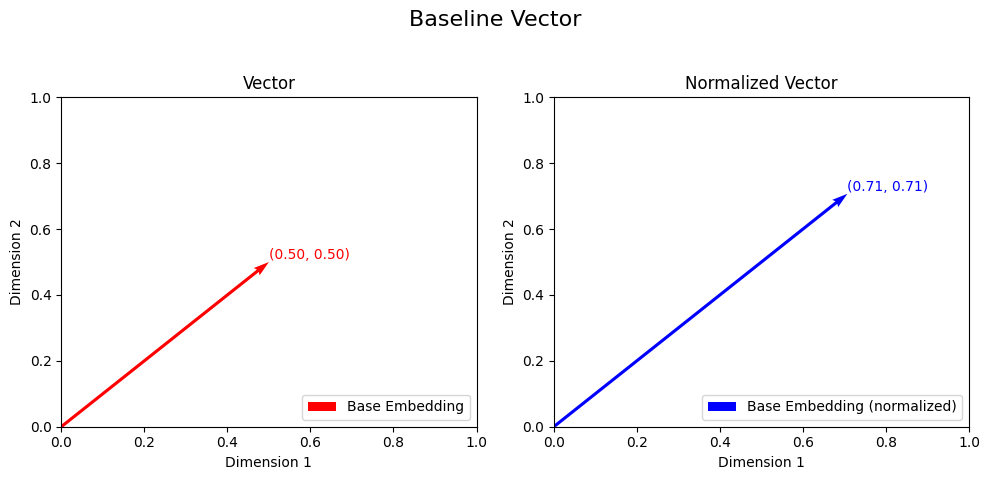

In [310]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Base Embedding
axs[0].quiver(0, 0, base_embedding[0], base_embedding[1], angles='xy', scale_units='xy', scale=1, color='red', label='Base Embedding')
axs[0].text(base_embedding[0], base_embedding[1], f"({base_embedding[0]:.2f}, {base_embedding[1]:.2f})", color='red', ha='left', va='bottom')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Vector')
axs[0].legend(loc='lower right')

# Plot 2: Normalized Base Embedding
axs[1].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[1].text(base_embedding_normalized[0], base_embedding_normalized[1], f"({base_embedding_normalized[0]:.2f}, {base_embedding_normalized[1]:.2f})", color='blue', ha='left', va='bottom')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Normalized Vector')
axs[1].legend(loc='lower right')

# Overall title for figure:
fig.suptitle('Baseline Vector', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Description**

A visual representation of an example vector and its normalized form.  Think of this as the query embedding that we want to find matches for.

### Comparison Vectors

Perhaps these represent the range of embeddings representing chunks of text in a vector database...

In [306]:
base_magnitude = np.linalg.norm(base_embedding)
magnitudes = [base_magnitude / 2, base_magnitude, base_magnitude * 2]
angles = [-20, 20, -45, 45, -90, 90, -135, 135, 180]


comparison_embeddings = []
comparison_embeddings_normalized = []
for magnitude in magnitudes:
    base_vector = base_embedding * (magnitude / base_magnitude)
    base_vector_normalized = base_vector / np.linalg.norm(base_vector, 2)
    for angle in angles:
        r = np.radians(angle)
        rotation_matrix = np.array([
            [np.cos(r), -np.sin(r)],
            [np.sin(r), np.cos(r)]
        ])
        new_vector = np.dot(rotation_matrix, base_vector)
        new_vector_normalized = new_vector / np.linalg.norm(new_vector, 2)
        comparison_embeddings.append(new_vector)
        comparison_embeddings_normalized.append(new_vector_normalized)
    comparison_embeddings.append(base_vector)
    comparison_embeddings_normalized.append(base_vector_normalized)
comparison_embeddings = np.array(comparison_embeddings)
comparison_embeddings_normalized = np.array(comparison_embeddings_normalized)

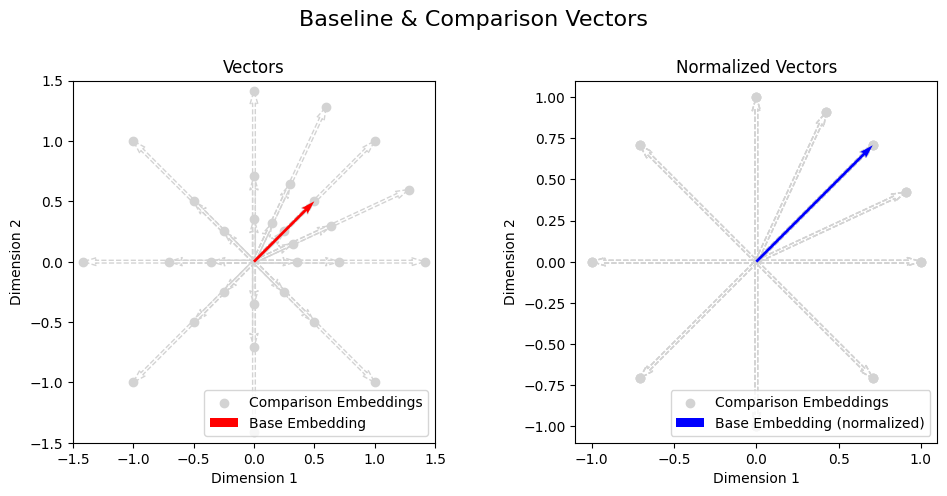

In [312]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Comparing Vectors
axs[0].scatter(comparison_embeddings[:, 0], comparison_embeddings[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings:
    axs[0].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
axs[0].quiver(0, 0, base_embedding[0], base_embedding[1], angles='xy', scale_units='xy', scale=1, color='red', label='Base Embedding')
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Vectors')
axs[0].legend(loc='lower right')
axs[0].set_aspect('equal')

# Plot 2: Comparing Normalized Vectors
axs[1].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[1].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
axs[1].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[1].set_xlim(-1.1, 1.1)
axs[1].set_ylim(-1.1, 1.1)
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Normalized Vectors')
axs[1].legend(loc='lower right')
axs[1].set_aspect('equal')

# Overall title for figure:
fig.suptitle('Baseline & Comparison Vectors', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Description**

A visual representation of the baseline embedding and a variety of comparison embedding at different angles and magnitudes.  Notice that the normalized vectors all have the same magnitude.  

---
### Euclidean Distance

Calculate the Euclidean distance between the baseline vector (query) and each of the comparison vectors (chunks embedded)...

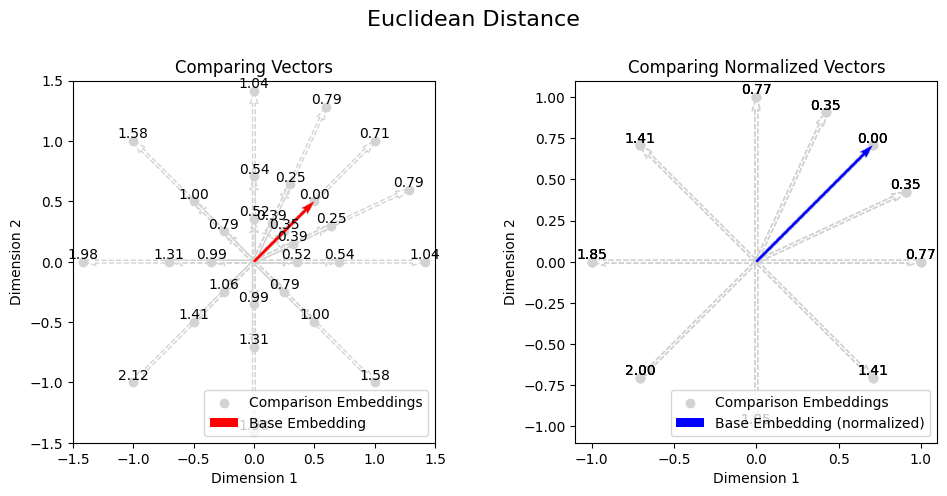

In [305]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Comparing Vectors
axs[0].scatter(comparison_embeddings[:, 0], comparison_embeddings[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings:
    axs[0].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.linalg.norm((base_embedding - e), 2)
    axs[0].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[0].quiver(0, 0, base_embedding[0], base_embedding[1], angles='xy', scale_units='xy', scale=1, color='red', label='Base Embedding')
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Comparing Vectors')
axs[0].legend(loc='lower right')
axs[0].set_aspect('equal')

# Plot 2: Comparing Normalized Vectors
axs[1].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[1].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.linalg.norm((base_embedding_normalized - e), 2)
    axs[1].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[1].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[1].set_xlim(-1.1, 1.1)
axs[1].set_ylim(-1.1, 1.1)
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Comparing Normalized Vectors')
axs[1].legend(loc='lower right')
axs[1].set_aspect('equal')

# Overall title for figure:
fig.suptitle('Euclidean Distance', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Description**

The Euclidean distances are intuitive and represent the straight line distance between the base embedding and the various comparison embeddings.  For the normalized vectors the magnitude is fixed at 1 so the distance represent the secant length across the unit circle to the comparison embeddings.  Of particular note are:
- for the non-normalized vectors:
    - the distance is highly sensitive to the length/magitude and even when the able between vectors is the same the distance can be very different:
        - at the base embedding, going +- 20 degrees shows a distance of 0.25 while longer vectors would have larger distances for the same angles
        - at the base embedding and comparision that is +-20 degrees will differ in distance depending on it being shorter/longer than the base embedding and in either case shown it is further from the base embedding (0.39 and 0.79).
    - note that smaller magnitude vectors with large angles may be deemed more similar than larger magnitude vectors with small angles
- for the normalized vectors:
    - the distance is more straight-forward so long as the range is understood [0, 2].
    - the distance is like a secant length that could also be measured by the angle between comparison and baseline, similar to either dot product or cosine similarity

---
### Dot Product Similarity Review

Calculate the dot product similarity between the baseline vector (query) and each of the comparison vectors (chunks embedded)...

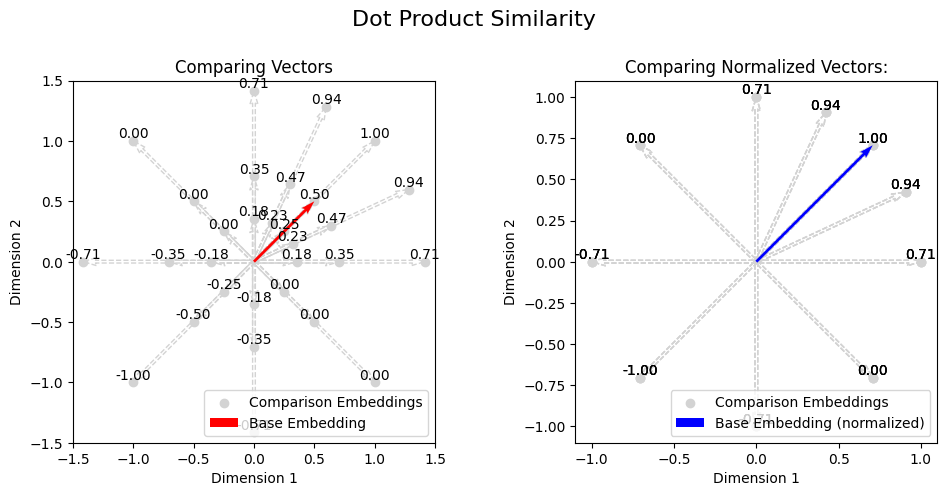

In [304]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Comparing Vectors
axs[0].scatter(comparison_embeddings[:, 0], comparison_embeddings[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings:
    axs[0].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.dot(base_embedding, e)
    axs[0].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[0].quiver(0, 0, base_embedding[0], base_embedding[1], angles='xy', scale_units='xy', scale=1, color='red', label='Base Embedding')
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Comparing Vectors')
axs[0].legend(loc='lower right')
axs[0].set_aspect('equal')

# Plot 2: Comparing Normalized Vectors
axs[1].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[1].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.dot(base_embedding_normalized, e)
    axs[1].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[1].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[1].set_xlim(-1.1, 1.1)
axs[1].set_ylim(-1.1, 1.1)
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Comparing Normalized Vectors:')
axs[1].legend(loc='lower right')
axs[1].set_aspect('equal')

# Overall title for figure:
fig.suptitle('Dot Product Similarity', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Description**

The dot product similarity of the normalized vectors offers a scale with easy interpretation:
- 0 values for comparison vectors that are othogonal to the baseline vector
- negative values for comparison vectors that are in the opposite direction of the baseline vector
- a range of positive value for comparison vectors that are in the same direction as the baseline vector with 1 being the exact same angle as the baseline vector

The non-normalized vectors offer similar ease of interpetation from a direction standpoint but the magnitudes of the comparison vectors can cause difficulty in interpretation when the overall scale is not well understood.

---
### Cosine Similarity Review

Calculate the cosine similarity between the baseline vector (query) and each of the comparison vectors (chunks embedded)...

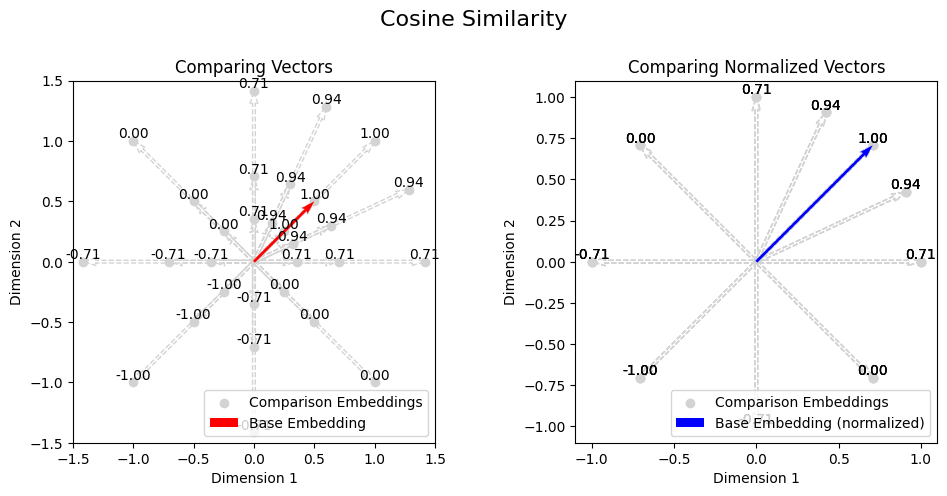

In [303]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Comparing Vectors
axs[0].scatter(comparison_embeddings[:, 0], comparison_embeddings[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings:
    axs[0].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.dot(base_embedding, e) / (np.linalg.norm(base_embedding, 2) * np.linalg.norm(e, 2))
    axs[0].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[0].quiver(0, 0, base_embedding[0], base_embedding[1], angles='xy', scale_units='xy', scale=1, color='red', label='Base Embedding')
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Comparing Vectors')
axs[0].legend(loc='lower right')
axs[0].set_aspect('equal')

# Plot 2: Comparing Normalized Vectors
axs[1].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[1].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.dot(base_embedding_normalized, e) / (np.linalg.norm(base_embedding_normalized, 2) * np.linalg.norm(e, 2))
    axs[1].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[1].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[1].set_xlim(-1.1, 1.1)
axs[1].set_ylim(-1.1, 1.1)
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Comparing Normalized Vectors')
axs[1].legend(loc='lower right')
axs[1].set_aspect('equal')

# Overall title for figure:
fig.suptitle('Cosine Similarity', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Description**

As expected the scale of the comparisons is easy to interpret for both normalized and non-normalized vectors:
- 0 value indicate comparisions that are orthogonal to the baseline vector
- negative values range from (0, -1] and represent comparisons that are in the opposite direction of the baseline vector
- positive values range from (0, 1] and represent comparisons that are in the same general direction as the baseline vector
- The magnitude does not change the value so the normalized vectors actually provide the same interpretation as the non-normalized vectors

---
## Comparing Distance Measures

The interpretation in the previous section motivate the normalzied vectors as being equal or better for interpretation for each of the similarity measures.

Plase the normalized interpretation side-by-side here:

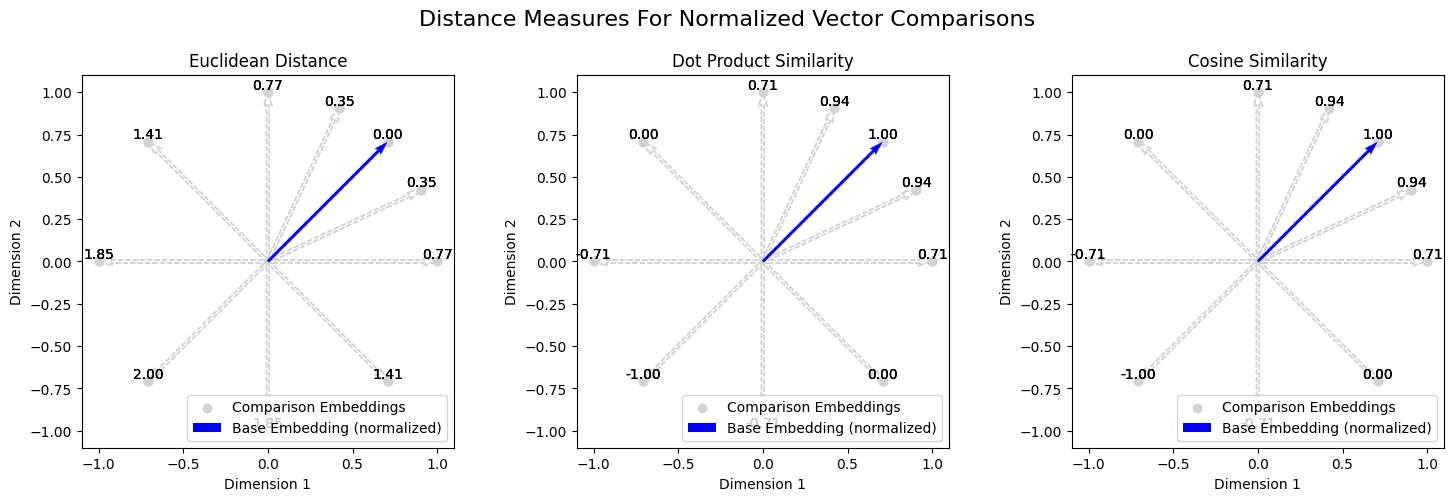

In [314]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Euclidean Distance
axs[0].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[0].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.linalg.norm((base_embedding_normalized - e), 2)
    axs[0].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[0].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[0].set_xlim(-1.1, 1.1)
axs[0].set_ylim(-1.1, 1.1)
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Euclidean Distance')
axs[0].legend(loc='lower right')
axs[0].set_aspect('equal')

# Plot 2: Dot Product Similarity
axs[1].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[1].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.dot(base_embedding_normalized, e)
    axs[1].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[1].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[1].set_xlim(-1.1, 1.1)
axs[1].set_ylim(-1.1, 1.1)
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Dot Product Similarity')
axs[1].legend(loc='lower right')
axs[1].set_aspect('equal')

# Plot 3: Cosine Similarity
axs[2].scatter(comparison_embeddings_normalized[:, 0], comparison_embeddings_normalized[:, 1], color='lightgrey', label='Comparison Embeddings')
for e in comparison_embeddings_normalized:
    axs[2].quiver(0, 0, e[0], e[1], angles='xy', scale_units='xy', scale=1, color='lightgrey', linewidths=1, linestyle='--', facecolor='none', edgecolor='lightgrey')
    dist = np.dot(base_embedding_normalized, e) / (np.linalg.norm(base_embedding_normalized, 2) * np.linalg.norm(e, 2))
    axs[2].text(e[0], e[1], f"{dist:.2f}", color='black', ha='center', va='bottom')
axs[2].quiver(0, 0, base_embedding_normalized[0], base_embedding_normalized[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Base Embedding (normalized)')
axs[2].set_xlim(-1.1, 1.1)
axs[2].set_ylim(-1.1, 1.1)
axs[2].set_xlabel('Dimension 1')
axs[2].set_ylabel('Dimension 2')
axs[2].set_title('Cosine Similarity')
axs[2].legend(loc='lower right')
axs[2].set_aspect('equal')

# Overall title for figure:
fig.suptitle('Distance Measures For Normalized Vector Comparisons', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plo

comparison table here

---
## Vector Search 

Using normalized embeddings to color code the distance metric by distance from a query embedding.  Show the result and top 10 matches in both the normalized and non-normalized embedding space.

### Embeddings (vectors)

In [319]:
query_embedding = embeddings[0]
query_embedding_normalized = embeddings_normalized[0]

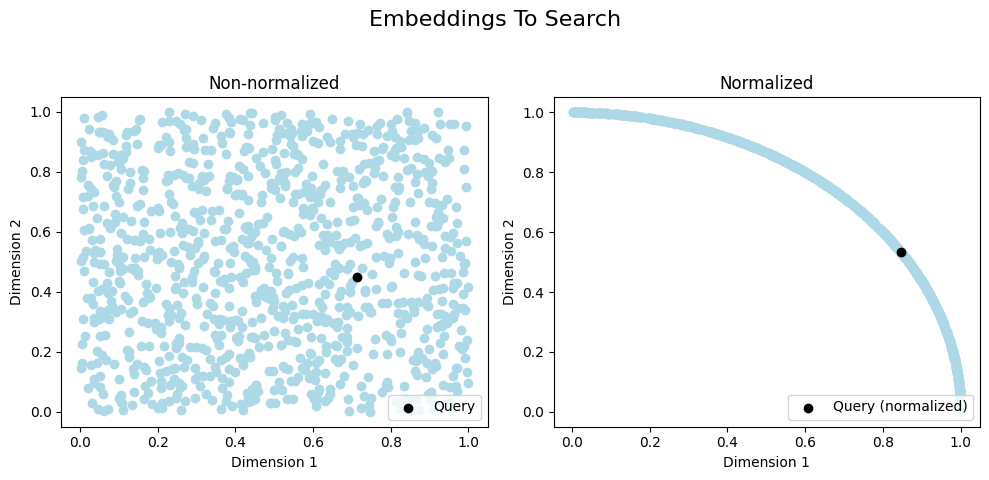

In [322]:
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Embeddings To Search
axs[0].scatter(embeddings[:, 0], embeddings[:, 1], color='lightblue')
axs[0].scatter(query_embedding[0], query_embedding[1], color='black', label='Query')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Non-normalized')
axs[0].legend(loc='lower right')

# Plot 2: Embeddings To Search: Normalized
axs[1].scatter(embeddings_normalized[:, 0], embeddings_normalized[:, 1], color='lightblue')
axs[1].scatter(query_embedding_normalized[0], query_embedding_normalized[1], color='black', label='Query (normalized)')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Normalized')
axs[1].legend(loc='lower right')

# Overall title for figure:
fig.suptitle('Embeddings To Search', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

---
### Euclidean Distance

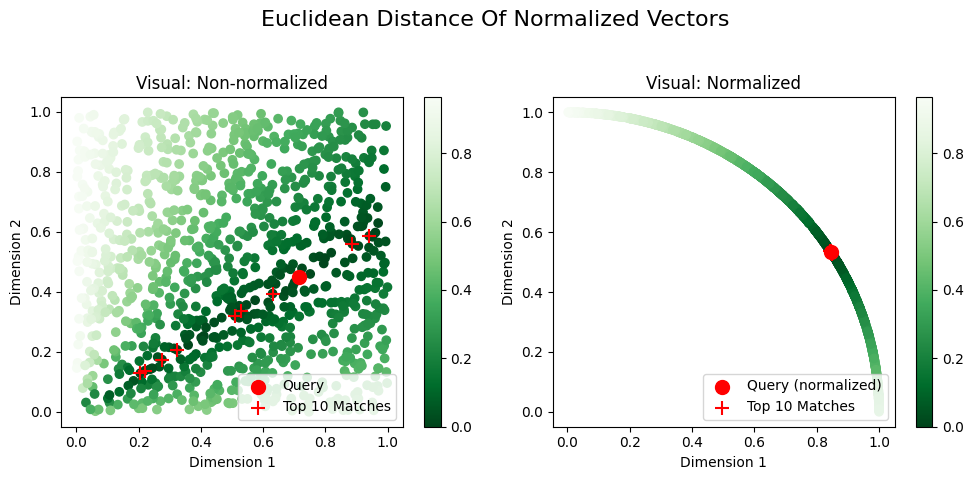

In [356]:
distances = []
for embedding in embeddings_normalized:
    distances.append(np.linalg.norm((query_embedding_normalized - embedding), 2))

# Find the indices of the 10 best matches
top_10_indices = np.argsort(distances)[0:10]
    
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Embeddings To Search
im0 = axs[0].scatter(embeddings[:, 0], embeddings[:, 1], c=distances, cmap=plt.cm.Greens_r)
axs[0].scatter(query_embedding[0], query_embedding[1], color='red', marker='o', s=100, label='Query')
axs[0].scatter(embeddings[top_10_indices, 0], embeddings[top_10_indices, 1], c='red', marker='+', s=100, label = 'Top 10 Matches')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Visual: Non-normalized')
axs[0].legend(loc='lower right')

# Plot 2: Embeddings To Search: Normalized
im1 = axs[1].scatter(embeddings_normalized[:, 0], embeddings_normalized[:, 1], c=distances, cmap=plt.cm.Greens_r)
axs[1].scatter(query_embedding_normalized[0], query_embedding_normalized[1], color='red', marker='o', s=100, label='Query (normalized)')
axs[1].scatter(embeddings_normalized[top_10_indices, 0], embeddings_normalized[top_10_indices, 1], c='red', marker='+', s=100, label = 'Top 10 Matches')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Visual: Normalized')
axs[1].legend(loc='lower right')

# Add colorbars
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])

# Overall title for figure:
fig.suptitle('Euclidean Distance Of Normalized Vectors', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

---
### Dot Product Similarity

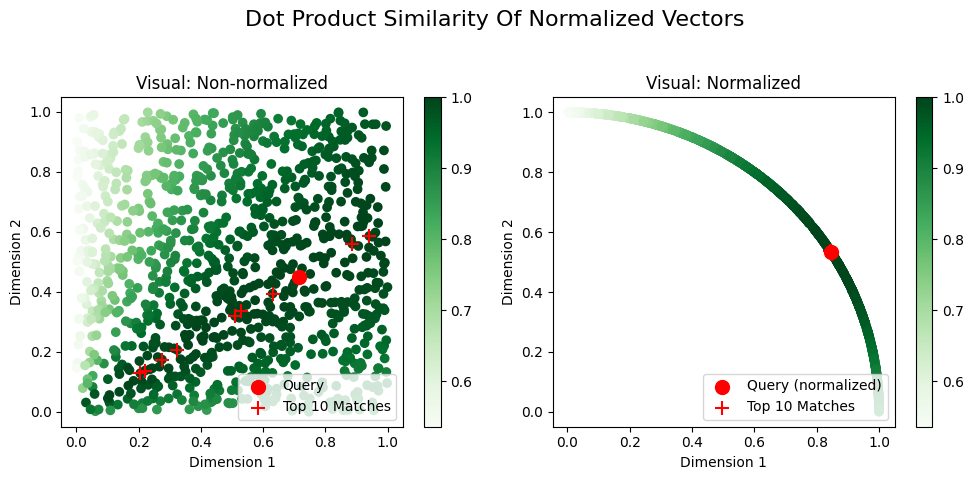

In [354]:
distances = []
for embedding in embeddings_normalized:
    distances.append(np.dot(query_embedding_normalized, embedding))

# Find the indices of the 10 best matches
top_10_indices = np.argsort(distances)[-10:]
    
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Embeddings To Search
im0 = axs[0].scatter(embeddings[:, 0], embeddings[:, 1], c=distances, cmap=plt.cm.Greens)
axs[0].scatter(query_embedding[0], query_embedding[1], color='red', marker='o', s=100, label='Query')
axs[0].scatter(embeddings[top_10_indices, 0], embeddings[top_10_indices, 1], c='red', marker='+', s=100, label = 'Top 10 Matches')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Visual: Non-normalized')
axs[0].legend(loc='lower right')

# Plot 2: Embeddings To Search: Normalized
im1 = axs[1].scatter(embeddings_normalized[:, 0], embeddings_normalized[:, 1], c=distances, cmap=plt.cm.Greens)
axs[1].scatter(query_embedding_normalized[0], query_embedding_normalized[1], color='red', marker='o', s=100, label='Query (normalized)')
axs[1].scatter(embeddings_normalized[top_10_indices, 0], embeddings_normalized[top_10_indices, 1], c='red', marker='+', s=100, label = 'Top 10 Matches')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Visual: Normalized')
axs[1].legend(loc='lower right')

# Add colorbars
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])

# Overall title for figure:
fig.suptitle('Dot Product Similarity Of Normalized Vectors', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()

---
### Cosine Similaritty

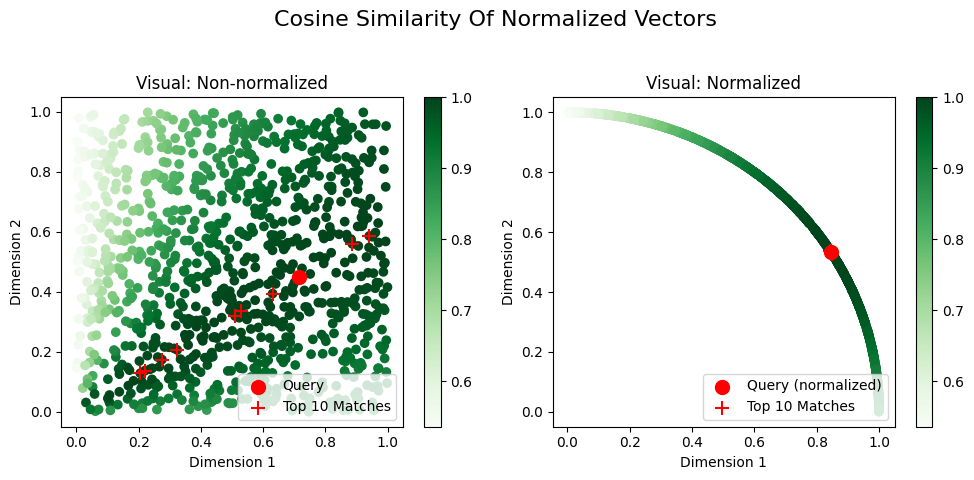

In [352]:
distances = []
for embedding in embeddings:
    distances.append(np.dot(query_embedding_normalized, embedding) / (np.linalg.norm(query_embedding_normalized, 2) * np.linalg.norm(embedding, 2)))

# Find the indices of the 10 best matches
top_10_indices = np.argsort(distances)[-10:]
    
# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot 1: Embeddings To Search
im0 = axs[0].scatter(embeddings[:, 0], embeddings[:, 1], c=distances, cmap=plt.cm.Greens)
axs[0].scatter(query_embedding[0], query_embedding[1], color='red', marker='o', s=100, label='Query')
axs[0].scatter(embeddings[top_10_indices, 0], embeddings[top_10_indices, 1], c='red', marker='+', s=100, label = 'Top 10 Matches')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].set_title('Visual: Non-normalized')
axs[0].legend(loc='lower right')

# Plot 2: Embeddings To Search: Normalized
im1 = axs[1].scatter(embeddings_normalized[:, 0], embeddings_normalized[:, 1], c=distances, cmap=plt.cm.Greens)
axs[1].scatter(query_embedding_normalized[0], query_embedding_normalized[1], color='red', marker='o', s=100, label='Query (normalized)')
axs[1].scatter(embeddings_normalized[top_10_indices, 0], embeddings_normalized[top_10_indices, 1], c='red', marker='+', s=100, label = 'Top 10 Matches')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].set_title('Visual: Normalized')
axs[1].legend(loc='lower right')

# Add colorbars
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])

# Overall title for figure:
fig.suptitle('Cosine Similarity Of Normalized Vectors', fontsize = 16)

# Adjust layout
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

# Show the plot
plt.show()